# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numba import njit
from tqdm import tqdm
import scipy.sparse as sp

import networkx as nx

In [5]:
data_trans_filtered = pd.read_csv('./finale_filtered.csv')

In [13]:
num_items = 10_000
items_freq = data_trans_filtered['material'].value_counts()[:num_items]
items_freq.to_csv('items_freq.csv')

tmp = items_freq.reset_index()['index']
item_to_idx = pd.Series(data = tmp.index, index = tmp.values)
item_to_idx.to_csv('items_to_index.csv')
idx_to_item = pd.Series(data = tmp.values, index = tmp.index)

In [17]:
data_trans_filtered = data_trans_filtered[data_trans_filtered['material'].isin(item_to_idx.index)]

In [18]:
basket = data_trans_filtered.groupby('chq_id').material.apply(list)

In [19]:
@njit
def iter_comatrix(comatrix, sum_item, items):
    for j in range(len(items)):
        sum_item[items[j]] += 1
        for k in range(j+1, len(items)):
            z1, z2 = items[j], items[k]
            comatrix[z1, z2] += 1
            comatrix[z2, z1] += 1
    

In [20]:
comatrix = np.zeros((num_items, num_items), dtype='int')
sum_item = np.zeros((num_items, ), dtype='int')
for i in tqdm(range(len(basket))):
    items = list(set(basket[i]))
    items = [item_to_idx[items[i]] for i in range(len(items))]
    iter_comatrix(comatrix, sum_item, items)

  0%|          | 0/1890876 [00:00<?, ?it/s]/home/ruslan/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'items' of function 'iter_comatrix'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-19-2b11ee35c6ed>", line 2:
@njit
def iter_comatrix(comatrix, sum_item, items):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
100%|██████████| 1890876/1890876 [00:38<00:00, 48517.36it/s]


In [21]:
def calculate_lift_matrix(comatrix, sum_item):
    return (comatrix / sum_item[:, None]) / (sum_item[None, :] / len(basket))

In [22]:
def calculate_confidence_matrix(comatrix, sum_item):
    return comatrix / sum_item[None, :]

In [133]:
lift_matrix = calculate_lift_matrix(comatrix, sum_item)

In [134]:
adj_matrix = lift_matrix.copy()
adj_matrix[adj_matrix <= 1] = 0


In [138]:
(adj_matrix > 0).sum()/10_000**2

0.13294

# Networkx

In [26]:
import networkx as nx

In [27]:
G = nx.convert_matrix.from_numpy_array(adj_matrix)


In [28]:
pr = nx.pagerank(G)

In [88]:
vs = np.array(list(pr.values()))

(array([1.000e+00, 1.400e+01, 1.560e+02, 1.034e+03, 3.162e+03, 4.311e+03,
        1.068e+03, 1.960e+02, 4.800e+01, 1.000e+01]),
 array([2.37869780e-05, 3.87665686e-05, 5.37461591e-05, 6.87257497e-05,
        8.37053402e-05, 9.86849307e-05, 1.13664521e-04, 1.28644112e-04,
        1.43623702e-04, 1.58603293e-04, 1.73582883e-04]),
 <a list of 10 Patch objects>)

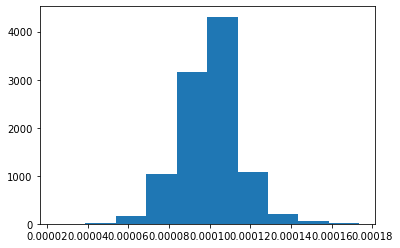

In [46]:
plt.hist(vs)

In [127]:
list_product = list(idx_to_item[vs.argsort()[-100:]])

In [107]:
def get_sums(data, list_product):
    bool_flag = data.isin(list_product).material ### если хотя бы один из ключевых продуктов в чеке
    check_whith = data[bool_flag].chq_id.unique()
    check_whithout = data[~bool_flag].chq_id.unique()
#     only_key_prod_sum = data[bool_flag].groupby('chq_id').sales_sum.sum()
    all_sum = data.groupby('chq_id')['sales_count'].sum()
    sum_with = all_sum[check_whith] #- only_key_prod_sum
    sum_with_out = all_sum[check_whithout]
    return sum_with, sum_with_out

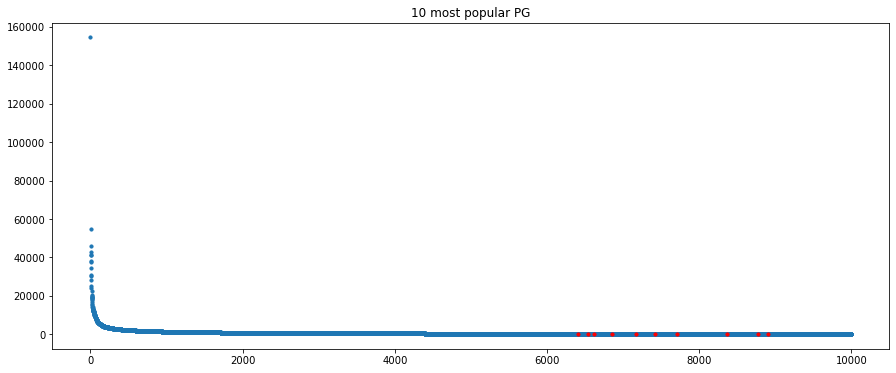

In [126]:
plt.figure(figsize=(15, 6))
plt.title('10 most popular PG')
plt.scatter(item_to_idx.values, items_freq.values, s=10)
plt.scatter(item_to_idx[list_product].values, items_freq[item_to_idx[list_product]].values, s=10, c='r')

In [108]:
diffs = get_sums(data_trans_filtered, list_product)

In [111]:
sum_with, sum_with_out = diffs

In [112]:
sum_with.mean(), sum_with_out.mean()

(8.843071944055916, 5.096707676273547)

In [113]:
sum_with.shape, sum_with_out.shape

((17875,), (1890175,))

# Importing for Gephi

In [152]:
H = nx.relabel_nodes(G, idx_to_item.to_dict())

In [153]:
nx.write_gexf(H, "lenta_graph.gexf")